In [1]:
import os
import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [2]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

# link = 'https://www.gutenberg.org/files/98/98-0.txt'  # a tale of two cities
link = 'http://www.gutenberg.org/cache/epub/2500/pg2500.txt'  # siddartha
text_path = link.split('/')[-1]
if not os.path.exists(text_path):
    !wget {link}

## Train wordvectors

In [3]:
wrdvec_path = './wrdvecs_100.bin'
if not os.path.exists(wrdvec_path):
    %time word2vec.word2vec(corpus_path, wrdvec_path, iter_=5, hs=1, threads=4, sample='1e-5', window=10, size=100, binary=1)

In [4]:
model = word2vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.vectors, index=model.vocab)
vecr = CountVectorizer(vocabulary=wrdvecs.index)

print(wrdvecs.shape)

(71291, 100)


## get sentence tokenizer

In [5]:
import nltk
nltk.download('punkt')
sentence_analyzer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /usr/local/lib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## run get_penalty and split_optimal

In [6]:
from textsplit.tools import get_segments, get_penalty
from textsplit.algorithm import split_optimal

with open(text_path, 'rt') as f:
    text = f.read().replace('\n', ' ')

sentenced_text = sentence_analyzer.tokenize(text)
sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], 10)  # segment target length in sentences

%time segmentation = split_optimal(sentence_vectors, penalty, seg_limit=100)
segmented_text = get_segments(sentenced_text, segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 134 ms
1972 sentences, 229 segments, avg 8.61 sentences per segment


## print example text with segment and sentence annotation

In [ ]:
for segment_sentences in segmented_text:
    segment_str = ' // '.join(segment_sentences)
    segment_str += '\n[%d sentences]' % len(segment_sentences)
    print('%s\n--------------------------------------' % segment_str)

## compare segment lenghts of greedy and optimal algorithm

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 23 ms


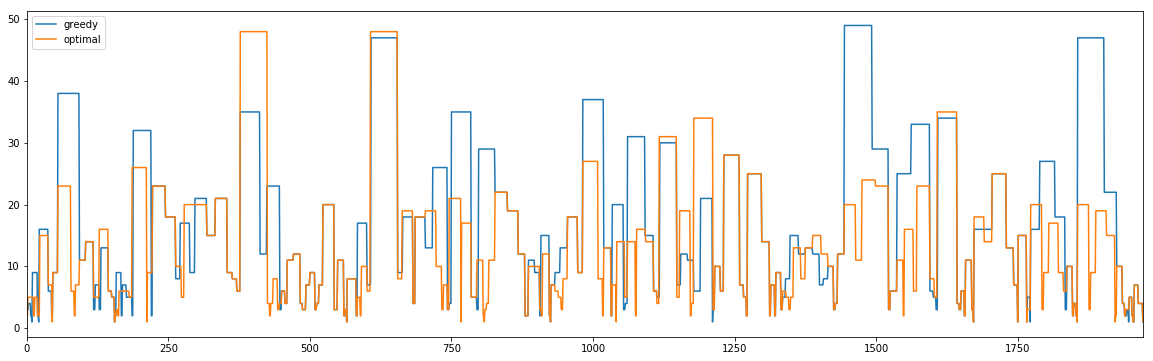

In [8]:
%matplotlib inline
from textsplit.tools import split_greedy
%time greedy_segmentation = split_greedy(sentence_vectors, penalty)
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(20,6))

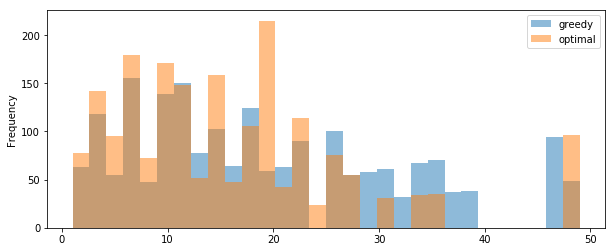

In [9]:
df.plot.hist(bins=30, alpha=0.5, figsize=(10,4))